In [21]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [1]:
# basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_predict, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.cluster import KMeans

#others
from xgboost import XGBRegressor
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
import time
import xarray as xr
import sherpa
import time
from scipy.spatial import Delaunay
from scipy import interpolate
from copy import deepcopy

# enable autoreload
%load_ext autoreload
%autoreload 2
# Variables from config file
from config import BASE_DIR, FILE_NAMES, LABELS, ATTRIBUTES, BEST_MODEL_COLUMNS
from math import pi as PI

# Train site-specific Linear Regression and compare the results with single-model XGBoost.

Input lables to use: Single observation from the closest observation, with lat, lon, seasonality, and elevation

In [2]:
columns = deepcopy(LABELS)
columns.extend(["data_in", "season_wet", "elevation", "lat", "lon"])
for item in columns:
    print(item, end=' ')

# load datasets
df_train = pd.read_csv(f"{BASE_DIR}/train.csv", usecols=columns + ['year', 'month', 'skn'])
df_valid = pd.read_csv(f"{BASE_DIR}/valid.csv", usecols=columns + ['year', 'month', 'skn'])
df_test = pd.read_csv(f"{BASE_DIR}/test.csv", usecols=columns + ['year', 'month', 'skn'])
df_combined = pd.concat([df_train, df_valid, df_test])

air2m air1000_500 hgt500 hgt1000 omega500 pottemp1000-500 pottemp1000-850 pr_wtr shum-uwnd-700 shum-uwnd-925 shum-vwnd-700 shum-vwnd-950 shum700 shum925 skt slp data_in season_wet elevation lat lon 

### Assign chrono-split index to each data: `n_folds = 5`

In [3]:
n_folds = 5

df_len_by_month = pd.DataFrame(df_combined.groupby(by=["year", "month"]).size()).reset_index().rename({0:"len"}, axis=1)
df_len_by_month['cumsum'] = df_len_by_month['len'].cumsum()

n_samples_total = df_len_by_month['cumsum'].iloc[-1]
n_samples_per_fold = np.ceil(n_samples_total / n_folds)

df_len_by_month['fold'] = df_len_by_month.apply(lambda row: int(row['cumsum'] / n_samples_per_fold), axis=1)

print("The numbers of examples in each fold")
for fold in range(5):
    print(df_len_by_month[df_len_by_month['fold'] == fold]['len'].sum())
    
df_combined = pd.merge(left=df_combined, right=df_len_by_month, left_on=["year", "month"], right_on=["year", "month"])

The numbers of examples in each fold
172693
172475
173153
174015
173225


## 1. No chrono-split

In [162]:
num_groups = df_combined['skn'].unique().shape[0]
df_result = []
for i, (skn, group) in enumerate(df_combined.groupby("skn")):# iterate the group object
    if group.shape[0] < 5: continue
    # Randomize the order: this causes high variance in performance
    group = group.sample(frac=1)
    group = group[columns]
    
    Y = np.array(group["data_in"])
    X = np.array(group.drop(["data_in"], axis=1))
    
    y_pred = cross_val_predict(LinearRegression(), X, Y, cv=5, n_jobs=-1)
    
    group["prediction_multi_linear"] = y_pred
    df_result.append(group)
    
    # print out the progress
    print(f"{i}/{num_groups}", end="\r")
print()

df_result = pd.concat(df_result)

rmse_multi_linear = mean_squared_error(df_result['data_in'], df_result['prediction_multi_linear'], squared=False)
print("RMSE with site-specific linear regression: {:.3f}".format(rmse_multi_linear))

1991/1992


In [50]:
# xgb
xgboost = XGBRegressor(
    n_estimators=280,
    learning_rate=0.1,
    max_depth=9,
    verbosity=0
)

Xtrain = np.array(df_train[columns].drop(["data_in"], axis=1))
Ytrain = np.array(df_train["data_in"])

Xtest = np.array(df_test[columns].drop(["data_in"], axis=1))
Ytest = np.array(df_test["data_in"])

xgboost.fit(Xtrain, Ytrain)
yhat = xgboost.predict(Xtest)
rmse_single_xgb = mean_squared_error(Ytest, yhat, squared=False)
print("RMSE with single xgboost regression: {:.3f}".format(rmse_single_xgb))

RMSE with single xgboost regression: 4.018


## 1.1 Apply chrono split

In [20]:
num_groups = df_combined['skn'].unique().shape[0]
df_result = []
for i, (skn, group) in enumerate(df_combined.groupby("skn")):# iterate the group object
    if group.shape[0] < 5: 
        # print(skn)
        continue
    # sort chronologically
    # enforce chrono split
    group.sort_values(by=["year", "month"], inplace=True)
    
    Y = np.array(group[columns]["data_in"])
    X = np.array(group[columns].drop(["data_in"], axis=1))
    
    y_pred = cross_val_predict(LinearRegression(), X, Y, cv=5, n_jobs=-1)
    
    group["prediction_multi_linear"] = y_pred
    df_result.append(group)
    
    # print out the progress
    print(f"{i}/{num_groups}", end="\r")
print()

df_result_linear = pd.concat(df_result).sort_index()

rmse_multi_linear = mean_squared_error(df_result_linear['data_in'], df_result_linear['prediction_multi_linear'], squared=False)
print("RMSE with site-specific linear regression: {:.6f}".format(rmse_multi_linear))

1991/1992
RMSE with site-specific linear regression: 4.098153


In [21]:
print("RMSE with site-specific linear regression: {:.10f}".format(rmse_multi_linear))

RMSE with site-specific linear regression: 4.0981529422


In [196]:
xgboost = XGBRegressor(
    n_estimators=280,
    learning_rate=0.1,
    max_depth=9,
    verbosity=0
)

start = time.time()
df_result = []
for fold in range(n_folds):
    print(f"Running the {fold}-th fold")
    df_train = df_combined[df_combined['fold'] != fold]
    df_test = df_combined[df_combined['fold'] == fold]
    
    Xtrain = np.array(df_train[columns].drop("data_in", axis=1))
    Ytrain = np.array(df_train["data_in"])
    
    Xtest = np.array(df_test[columns].drop("data_in", axis=1))
    Ytest = np.array(df_test["data_in"])
    
    xgboost.fit(Xtrain, Ytrain)
    
    yhat = xgboost.predict(Xtest)
    df_test['prediction_single_xgb'] = yhat
    df_result.append(df_test)
    
end = time.time()

df_result_xgb = pd.concat(df_result)

print(end - start)

Running the 0-th fold
Running the 1-th fold
Running the 2-th fold
Running the 3-th fold
Running the 4-th fold
274.9581937789917


In [217]:
df_result_linear["prediction_single_xgb"] = df_result_xgb["prediction_single_xgb"]
df_result_linear.to_csv(f"{BASE_DIR}/cv/chrono/result_vanila.csv", index=False)

<hr>

In [53]:
df_result = pd.read_csv(f"{BASE_DIR}/cv/chrono/result_vanila.csv")

In [54]:
rmse_per_station_linear = []
rmse_per_station_xgb = []
diff = [] # RMSE(linear) - RMSE(XGBoost)
n_data = []
skn = []
for name, group in df_result.groupby(by='skn'):
    rmse_linear = mean_squared_error(group['data_in'], group['prediction_multi_linear'], squared=False)
    rmse_xgb = mean_squared_error(group['data_in'], group['prediction_single_xgb'], squared=False)
    
    rmse_per_station_linear.append(rmse_linear)
    rmse_per_station_xgb.append(rmse_xgb)
    diff.append(rmse_linear - rmse_xgb)
    n_data.append(group.shape[0])
    skn.append(name)
    
df_result_per_station = pd.DataFrame(
    {
        'skn': skn,
        'n_data': n_data,
        'rmse_linear': rmse_per_station_linear,
        'rmse_xgb': rmse_per_station_xgb,
        'diff': diff
    }
)

In [55]:
rmse_linear = mean_squared_error(df_result['data_in'], df_result['prediction_multi_linear'], squared=False)
rmse_xgb = mean_squared_error(df_result['data_in'], df_result['prediction_single_xgb'], squared=False)

print("RMSE using site-specific Linear Regression models: {:.3f}".format(rmse_linear))
print("RMSE using a sigle XGBost model: {:.3f}".format(rmse_xgb))

RMSE using site-specific Linear Regression models: 4.098
RMSE using a sigle XGBost model: 3.998


## Conclusion: chrono split leads to better performance for some reason

<hr>

site-specific xgb vs site-specific linear regression for stations with large numbers of samples

In [ ]:
# implement cross_val_predict so that it can report mean trainig loss as well

In [29]:
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=False)
num_groups = df_combined['skn'].unique().shape[0]

mean_training_prediction = []
predictions = []
data_in = []

for i, (skn, group) in enumerate(df_combined.groupby("skn")):# iterate the group object
    if group.shape[0] < 5: 
        # print(skn)
        continue
    # sort chronologically
    # enforce chrono split
    group.sort_values(by=["year", "month"], inplace=True)
    
    Y = np.array(group[columns]["data_in"])
    X = np.array(group[columns].drop(["data_in"], axis=1))
    
    station_mean_training_prediction = np.zeros(Y.shape[0])
    station_predictions = np.zeros(Y.shape[0])
    
    for train_index, test_index in kf.split(X):
        Xtrain, Xtest = X[train_index], X[test_index]
        Ytrain, Ytest = Y[train_index], Y[test_index]
        
        linear_regression = LinearRegression()
        linear_regression.fit(Xtrain, Ytrain)
        
        # get predictions on training data and test data
        yhat_train = linear_regression.predict(Xtrain)
        yhat_test = linear_regression.predict(Xtest)
        
        station_predictions[test_index] = yhat_test
        station_mean_training_prediction[train_index] = station_mean_training_prediction[train_index] + yhat_train * (1.0/n_splits)
        
    
    predictions.extend(station_predictions)
    mean_training_prediction.extend(station_mean_training_prediction)
    data_in.extend(Y)
    
    print(f"{i}/{num_groups}", end="\r")
print()

1991/1992


In [32]:
mean_squared_error(data_in, predictions, squared=False), mean_squared_error(data_in, mean_training_prediction, squared=False)

(4.0981529422084675, 3.84806599502392)

In [ ]:
xgboost = XGBRegressor(
    n_estimators=280,
    learning_rate=0.1,
    max_depth=9,
    verbosity=0
)

start = time.time()
df_result = []
for fold in range(n_folds):
    print(f"Running the {fold}-th fold")
    df_train = df_combined[df_combined['fold'] != fold]
    df_test = df_combined[df_combined['fold'] == fold]
    
    Xtrain = np.array(df_train[columns].drop("data_in", axis=1))
    Ytrain = np.array(df_train["data_in"])
    
    Xtest = np.array(df_test[columns].drop("data_in", axis=1))
    Ytest = np.array(df_test["data_in"])
    
    xgboost.fit(Xtrain, Ytrain)
    
    yhat = xgboost.predict(Xtest)
    df_test['prediction_single_xgb'] = yhat
    df_result.append(df_test)
    
end = time.time()

df_result_xgb = pd.concat(df_result)

print(end - start)

In [78]:
# select a sampling station
s = df_combined.groupby('skn').size()
sample_skn = s.where(s>600).dropna().sample().values[0]

In [82]:
print(sample_skn)
columns = deepcopy(LABELS)
columns.extend(["data_in", "season_wet", "elevation", "lat", "lon"])
for item in columns:
    print(item, end=' ')

773.0
air2m air1000_500 hgt500 hgt1000 omega500 pottemp1000-500 pottemp1000-850 pr_wtr shum-uwnd-700 shum-uwnd-925 shum-vwnd-700 shum-vwnd-950 shum700 shum925 skt slp data_in season_wet elevation lat lon 

In [95]:
X = np.array(df_combined[df_combined['skn'] == sample_skn][columns].drop("data_in", axis=1))
Y = np.array(df_combined[df_combined['skn'] == sample_skn]["data_in"])

Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2)

linear_regression = LinearRegression()
xgboost = xgboost = XGBRegressor(
    n_estimators=280,
    learning_rate=0.1,
    max_depth=9,
    verbosity=0
)

linear_regression.fit(Xtrain, Ytrain)
xgboost.fit(Xtrain, Ytrain)

train_loss_linear = mean_squared_error(Ytrain, linear_regression.predict(Xtrain))
test_loss_linear = mean_squared_error(Ytest, linear_regression.predict(Xtest))

train_loss_xgb = mean_squared_error(Ytrain, xgboost.predict(Xtrain))
test_loss_xgb = mean_squared_error(Ytest, xgboost.predict(Xtest))

print(train_loss_linear, test_loss_linear)
print(train_loss_xgb, test_loss_xgb)

8.712067622092292 6.864472068261732
1.3893670287422222e-06 11.945087952306512


# 2. What happens if we use month information, instead of seasonal information?
For this experiment, remove Seasonality and use month information, represented by coordinates in an unit circle

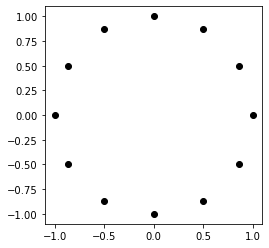

In [21]:
def month_to_coord(month):
    unit_angle = 2* np.pi / 12.0
    angle = unit_angle * month
    return (np.sin(angle), np.cos(angle))


fig, ax = plt.subplots(1)
for month in range(1, 13):
    # print(month_to_coord(month))
    coord = month_to_coord(month)
    ax.scatter(coord[0], coord[1], color='k')
ax.set_aspect("equal")

In [23]:
df_combined['month_x'] = df_combined.apply(lambda row: month_to_coord(row['month'])[0], axis=1)
df_combined['month_y'] = df_combined.apply(lambda row: month_to_coord(row['month'])[1], axis=1)

In [47]:
columns.extend(["month_x", "month_y"])
columns.remove("season_wet")

In [29]:
columns.append("season_wet")

In [44]:
columns.remove("month_x")
columns.remove("month_y")

In [45]:
columns

['air2m',
 'air1000_500',
 'hgt500',
 'hgt1000',
 'omega500',
 'pottemp1000-500',
 'pottemp1000-850',
 'pr_wtr',
 'shum-uwnd-700',
 'shum-uwnd-925',
 'shum-vwnd-700',
 'shum-vwnd-950',
 'shum700',
 'shum925',
 'skt',
 'slp',
 'data_in',
 'elevation',
 'lat',
 'lon',
 'season_wet']

In [46]:
num_groups = df_combined['skn'].unique().shape[0]
df_result = []
for i, (skn, group) in enumerate(df_combined.groupby("skn")):# iterate the group object
    if group.shape[0] < 5: 
        # print(skn)
        continue
    # sort chronologically
    # enforce chrono split
    group.sort_values(by=["year", "month"], inplace=True)
    
    Y = np.array(group[columns]["data_in"])
    X = np.array(group[columns].drop(["data_in"], axis=1))
    
    y_pred = cross_val_predict(LinearRegression(), X, Y, cv=5, n_jobs=-1)
    
    group["prediction_multi_linear"] = y_pred
    df_result.append(group)
    
    # print out the progress
    print(f"{i}/{num_groups}", end="\r")
print()

df_result_linear = pd.concat(df_result).sort_index()

rmse_multi_linear = mean_squared_error(df_result_linear['data_in'], df_result_linear['prediction_multi_linear'], squared=False)
print("RMSE with site-specific linear regression: {:.3f}".format(rmse_multi_linear))

1991/1992
RMSE with site-specific linear regression: 4.098


In [48]:
columns

['air2m',
 'air1000_500',
 'hgt500',
 'hgt1000',
 'omega500',
 'pottemp1000-500',
 'pottemp1000-850',
 'pr_wtr',
 'shum-uwnd-700',
 'shum-uwnd-925',
 'shum-vwnd-700',
 'shum-vwnd-950',
 'shum700',
 'shum925',
 'skt',
 'slp',
 'data_in',
 'elevation',
 'lat',
 'lon',
 'month_x',
 'month_y']

In [88]:
xgboost = XGBRegressor(
    n_estimators=280,
    learning_rate=0.1,
    max_depth=3,
    verbosity=0
)

start = time.time()
df_result = []
for fold in range(n_folds):
    print(f"Running the {fold}-th fold")
    df_train = df_combined[df_combined['fold'] != fold]
    df_test = df_combined[df_combined['fold'] == fold]
    
    Xtrain = np.array(df_train[columns].drop("data_in", axis=1))
    Ytrain = np.array(df_train["data_in"])
    
    Xtest = np.array(df_test[columns].drop("data_in", axis=1))
    Ytest = np.array(df_test["data_in"])
    
    xgboost.fit(Xtrain, Ytrain)
    
    yhat = xgboost.predict(Xtest)
    df_test['prediction_single_xgb'] = yhat
    df_result.append(df_test)
    
end = time.time()

df_result_xgb = pd.concat(df_result)

print(end - start)

Running the 0-th fold
Running the 1-th fold
Running the 2-th fold
Running the 3-th fold
Running the 4-th fold
68.35870623588562


In [89]:
mean_squared_error(df_result_xgb['data_in'], df_result_xgb['prediction_single_xgb'], squared=False)

4.392551083900696

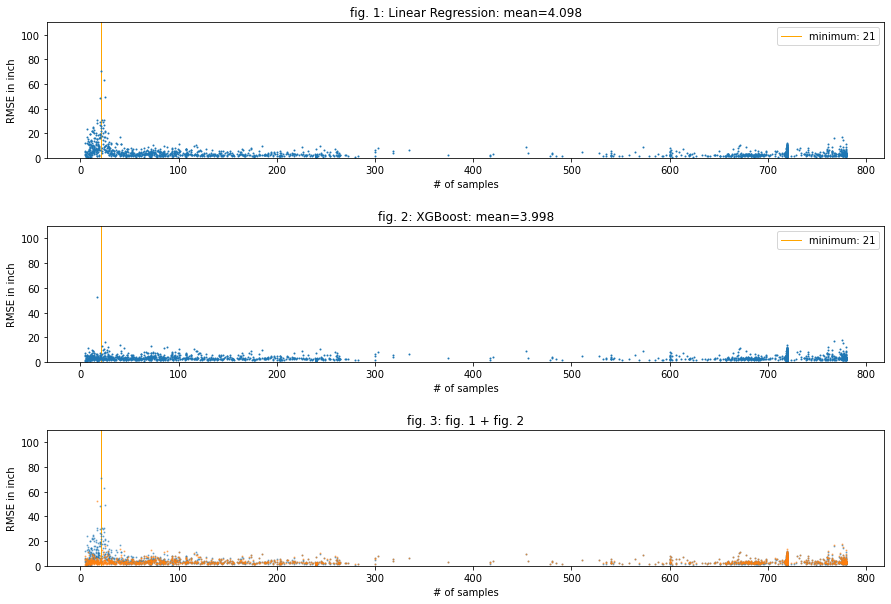

In [55]:
fig, ax = plt.subplots(
    3, figsize=(15,10),
    subplot_kw={
        'ylim': (0, 110),
        'xlabel': "# of samples",
        'ylabel': 'RMSE in inch'
    },
    gridspec_kw=dict(hspace=0.5, wspace=0.1)
)
ax[0].scatter(n_data, rmse_per_station_linear, s=1)
ax[1].scatter(n_data, rmse_per_station_xgb, s=1)

ax[2].scatter(n_data, rmse_per_station_linear, s=1, alpha=0.5)
ax[2].scatter(n_data, rmse_per_station_xgb, s=1, alpha=0.5)

ax[0].set_title("fig. 1: Linear Regression: mean={:.3f}".format(rmse_linear))
ax[1].set_title("fig. 2: XGBoost: mean={:.3f}".format(rmse_xgb))
ax[2].set_title("fig. 3: fig. 1 + fig. 2")

ax[0].axvline(x=len(columns), color='orange', linewidth=1, label=f"minimum: {len(columns)}", zorder=-1)
ax[1].axvline(x=len(columns), color='orange', linewidth=1, label=f"minimum: {len(columns)}", zorder=-1)
ax[2].axvline(x=len(columns), color='orange', linewidth=1, label=f"minimum: {len(columns)}", zorder=-1)
#ax[1].axvline(x=127, color='orange', linewidth=2, label="minimum: 127")
#ax[2].axvline(x=127, color='orange', linewidth=2, label="minimum: 127")

ax[0].legend()
ax[1].legend()
print()

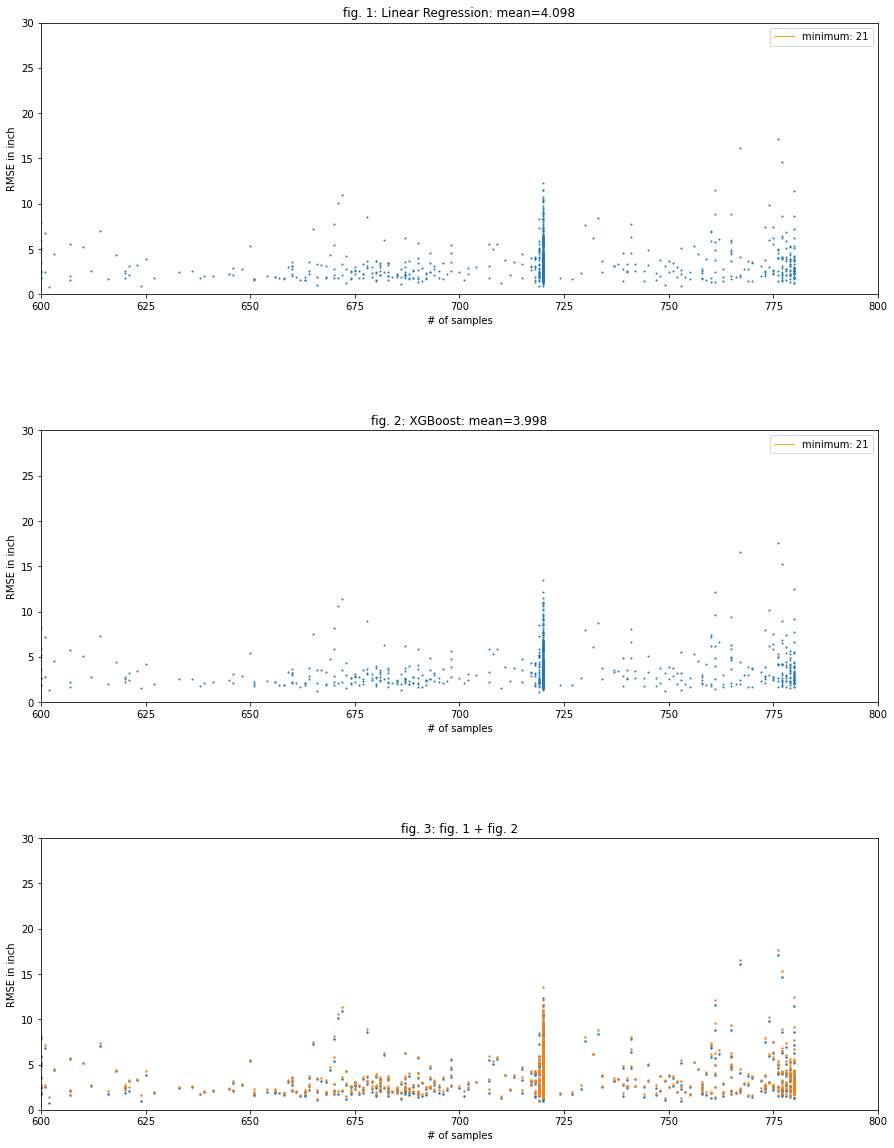

In [62]:
fig, ax = plt.subplots(
    3, figsize=(15,20),
    subplot_kw={
        'xlim': (600, 800),
        'ylim': (0, 30),
        'xlabel': "# of samples",
        'ylabel': 'RMSE in inch'
    },
    gridspec_kw=dict(hspace=0.5, wspace=0.1)
)
ax[0].scatter(n_data, rmse_per_station_linear, s=1)
ax[1].scatter(n_data, rmse_per_station_xgb, s=1)

ax[2].scatter(n_data, rmse_per_station_linear, s=2, alpha=1)
ax[2].scatter(n_data, rmse_per_station_xgb, s=2, alpha=1)

ax[0].set_title("fig. 1: Linear Regression: mean={:.3f}".format(rmse_linear))
ax[1].set_title("fig. 2: XGBoost: mean={:.3f}".format(rmse_xgb))
ax[2].set_title("fig. 3: fig. 1 + fig. 2")

ax[0].axvline(x=len(columns), color='orange', linewidth=1, label=f"minimum: {len(columns)}", zorder=-1)
ax[1].axvline(x=len(columns), color='orange', linewidth=1, label=f"minimum: {len(columns)}", zorder=-1)
ax[2].axvline(x=len(columns), color='orange', linewidth=1, label=f"minimum: {len(columns)}", zorder=-1)
#ax[1].axvline(x=127, color='orange', linewidth=2, label="minimum: 127")
#ax[2].axvline(x=127, color='orange', linewidth=2, label="minimum: 127")

ax[0].legend()
ax[1].legend()
print()

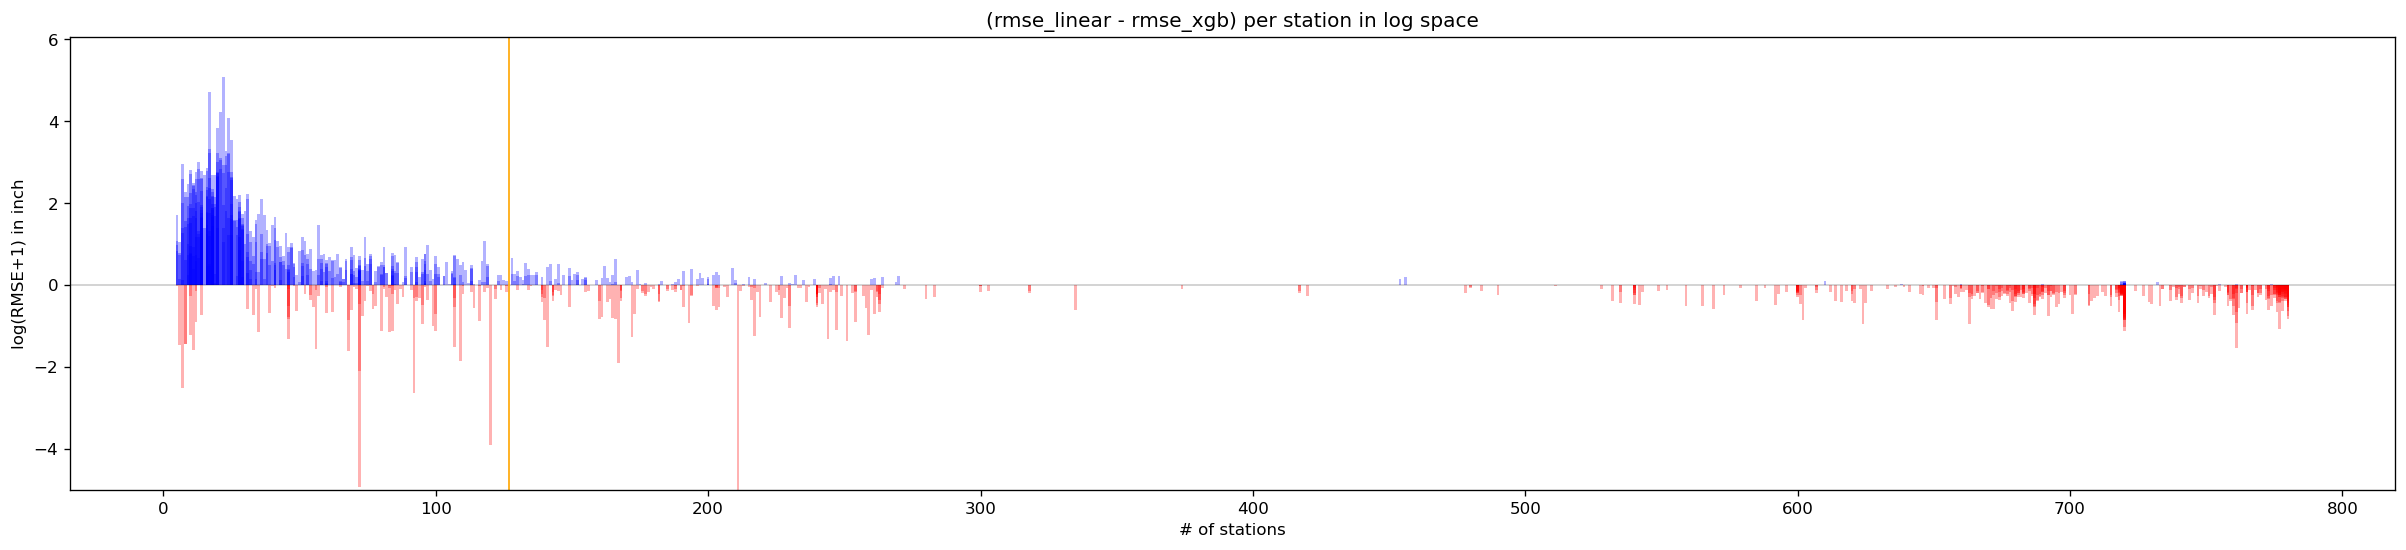

In [300]:
fig, ax = plt.subplots(1, figsize=(25,5), dpi=120)
ax.bar(
    x=df_result_per_station['n_data'],
    # height=np.log(1 + df_comparison_mean['diff']),
    # height=diff,
    height = np.log(1 + np.array(df_result_per_station['diff'])),
    width=1,
    color=['b' if item >= 0 else 'r' for item in df_result_per_station['diff']],
    alpha=0.3
)
ax.set_ylim((-5, np.log(np.max(diff)) + 1))
ax.axhline(y=0, linestyle='-', linewidth=1, color='k', alpha=0.2)
ax.axvline(127, linewidth=1, color='orange')
ax.set_title("(rmse_linear - rmse_xgb) per station in log space")
ax.set_xlabel('# of stations')
ax.set_ylabel('log(RMSE+1) in inch')
print()

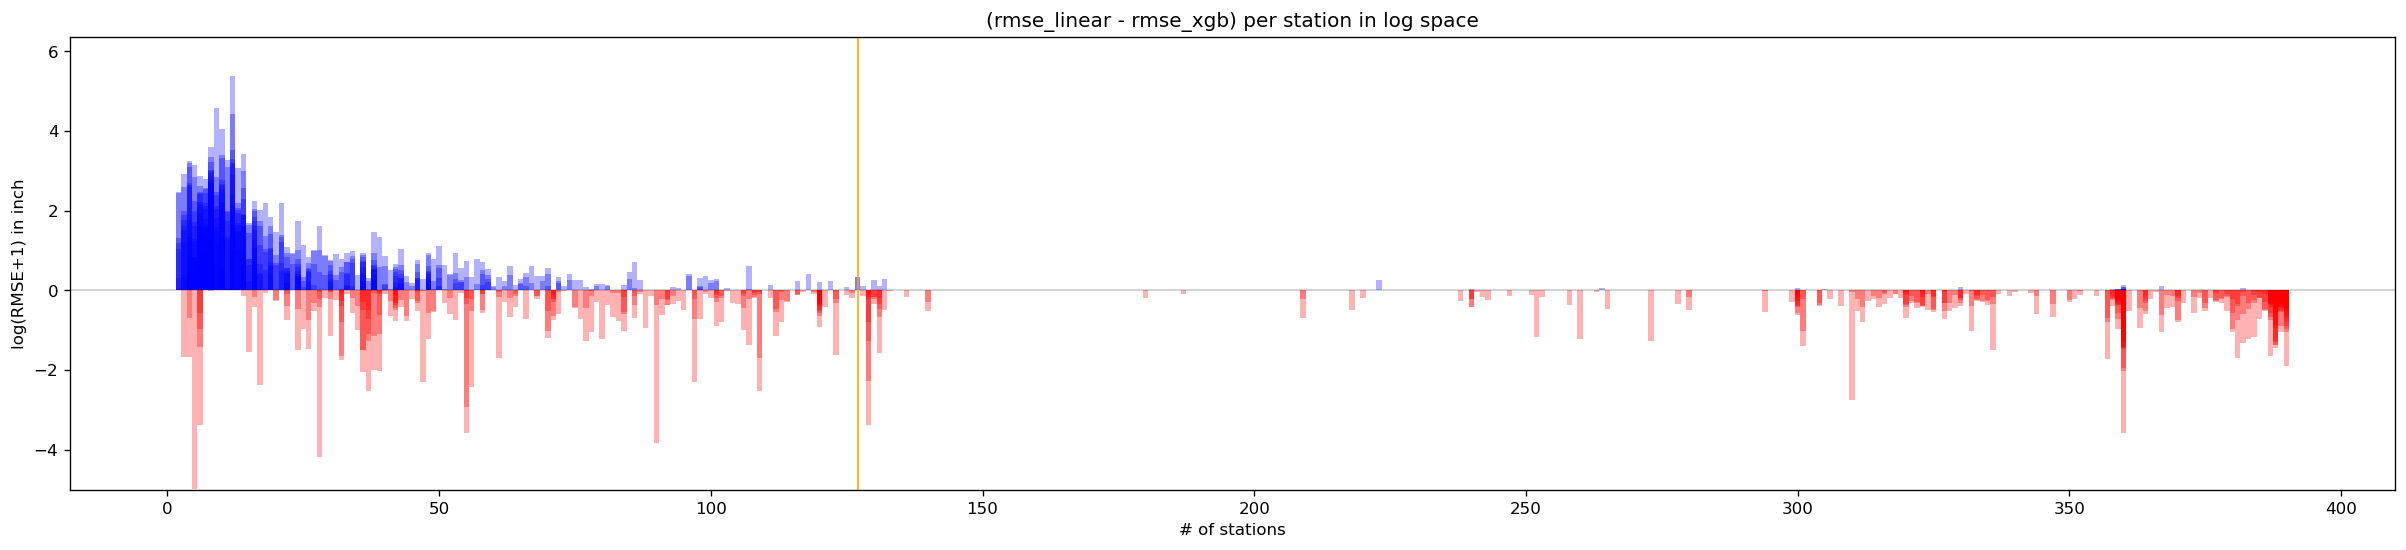

In [305]:
rmse_per_station_linear = []
rmse_per_station_xgb = []
diff = [] # RMSE(linear) - RMSE(XGBoost)
n_data = []
skn = []
for name, group in df_result[df_result['season_wet'] == 1].groupby(by='skn'):
    rmse_linear = mean_squared_error(group['data_in'], group['prediction_multi_linear'], squared=False)
    rmse_xgb = mean_squared_error(group['data_in'], group['prediction_single_xgb'], squared=False)
    
    rmse_per_station_linear.append(rmse_linear)
    rmse_per_station_xgb.append(rmse_xgb)
    diff.append(rmse_linear - rmse_xgb)
    n_data.append(group.shape[0])
    skn.append(name)
    
df_result_per_station_wet = pd.DataFrame(
    {
        'skn': skn,
        'n_data': n_data,
        'rmse_linear': rmse_per_station_linear,
        'rmse_xgb': rmse_per_station_xgb,
        'diff': diff
    }
)

fig, ax = plt.subplots(1, figsize=(25,5), dpi=120)
ax.bar(
    x=df_result_per_station_wet['n_data'],
    height = np.log(1 + np.array(df_result_per_station_wet['diff'])),
    width=1,
    color=['b' if item >= 0 else 'r' for item in df_result_per_station_wet['diff']],
    alpha=0.3
)
ax.set_ylim((-5, np.log(np.max(diff)) + 1))
ax.axhline(y=0, linestyle='-', linewidth=1, color='k', alpha=0.2)
ax.axvline(127, linewidth=1, color='orange')
ax.set_title("(rmse_linear - rmse_xgb) per station in log space")
ax.set_xlabel('# of stations')
ax.set_ylabel('log(RMSE+1) in inch')
print()

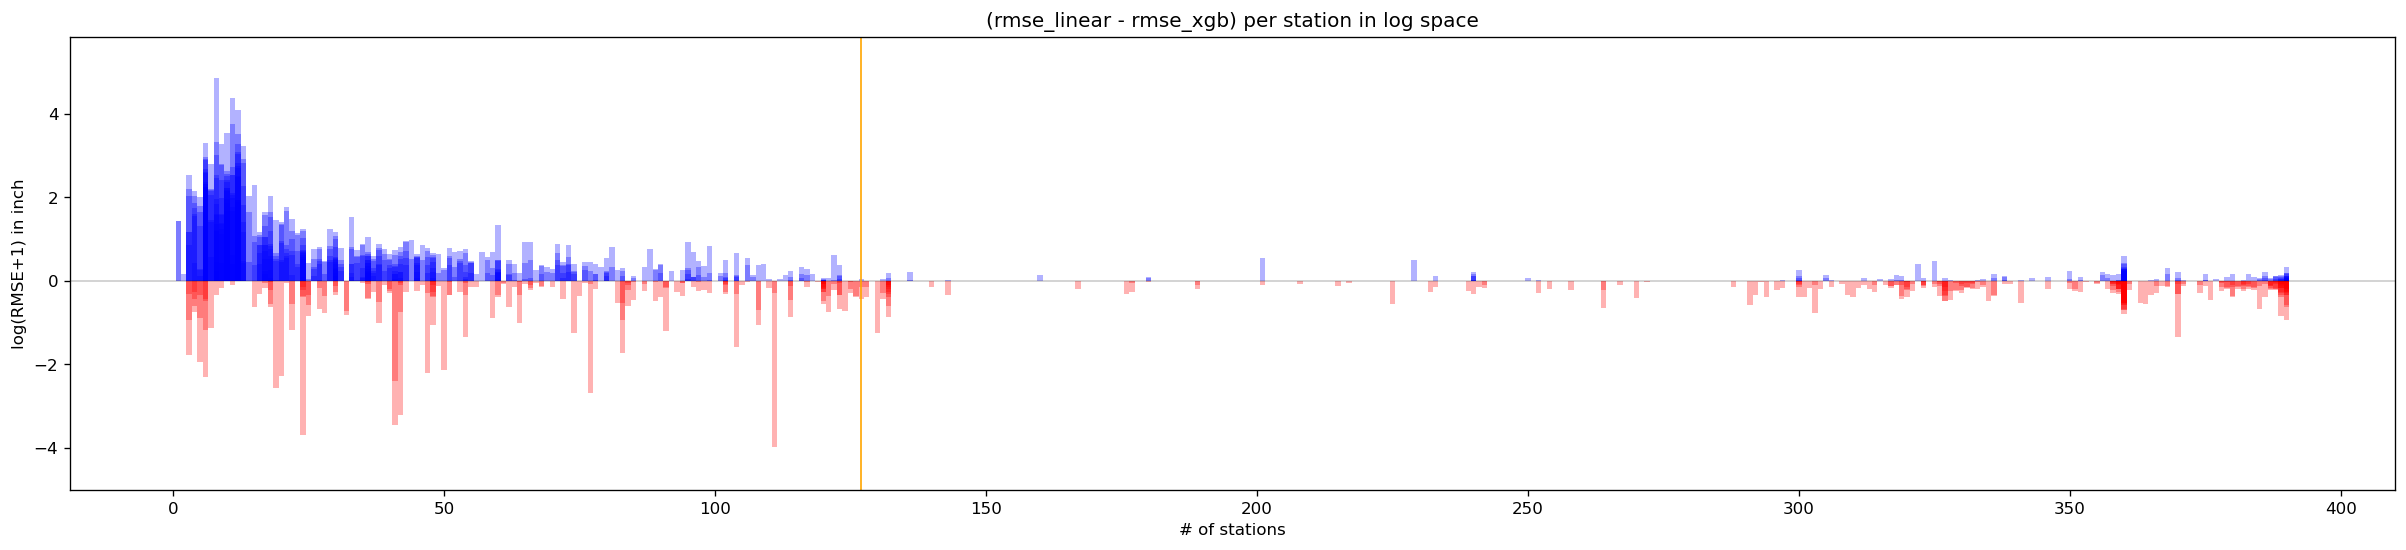

In [306]:
rmse_per_station_linear = []
rmse_per_station_xgb = []
diff = [] # RMSE(linear) - RMSE(XGBoost)
n_data = []
skn = []
for name, group in df_result[df_result['season_wet'] == 0].groupby(by='skn'):
    rmse_linear = mean_squared_error(group['data_in'], group['prediction_multi_linear'], squared=False)
    rmse_xgb = mean_squared_error(group['data_in'], group['prediction_single_xgb'], squared=False)
    
    rmse_per_station_linear.append(rmse_linear)
    rmse_per_station_xgb.append(rmse_xgb)
    diff.append(rmse_linear - rmse_xgb)
    n_data.append(group.shape[0])
    skn.append(name)
    
df_result_per_station_dry = pd.DataFrame(
    {
        'skn': skn,
        'n_data': n_data,
        'rmse_linear': rmse_per_station_linear,
        'rmse_xgb': rmse_per_station_xgb,
        'diff': diff
    }
)

fig, ax = plt.subplots(1, figsize=(25,5), dpi=120)
ax.bar(
    x=df_result_per_station_dry['n_data'],
    height = np.log(1 + np.array(df_result_per_station_dry['diff'])),
    width=1,
    color=['b' if item >= 0 else 'r' for item in df_result_per_station_dry['diff']],
    alpha=0.3
)
ax.set_ylim((-5, np.log(np.max(diff)) + 1))
ax.axhline(y=0, linestyle='-', linewidth=1, color='k', alpha=0.2)
ax.axvline(127, linewidth=1, color='orange')
ax.set_title("(rmse_linear - rmse_xgb) per station in log space")
ax.set_xlabel('# of stations')
ax.set_ylabel('log(RMSE+1) in inch')
print()

# insights on training loss: LOOCV

In [ ]:
# choose a specific station from the training data
# fit linear regression model, 80/20 split
# fit xgb on the other stations, make predictions: but what is training loss in this case??

# What would make linear regression fit easier?
# Since linear regression has each model per station, if by-station std decreases as the number of samples increases, then it would be beneficial to LR.
# => which is beneficial to xgb as well.

In [21]:
df_result_per_station[df_result_per_station['diff'] < 0]['skn']

0          1.00
2          2.00
12         2.20
15         2.25
16         2.26
         ...   
1938    1142.00
1939    1143.00
1940    1144.00
1941    1145.00
1942    1146.00
Name: skn, Length: 1360, dtype: float64

In [40]:
wow = 0
meh = 0
weird_skn = df_result_per_station[df_result_per_station['diff'] < 0]['skn']
for sample_skn in weird_skn:

    X = df_combined[df_combined['skn'] == sample_skn][columns].drop("data_in", axis=1)
    Y = df_combined[df_combined['skn'] == sample_skn]['data_in']

    Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2)

    model = LinearRegression()
    model.fit(Xtrain, Ytrain)
    yhat_train = model.predict(Xtrain)
    yhat_test = model.predict(Xtest)
    
    if mean_squared_error(Ytrain, yhat_train, squared=False) > mean_squared_error(Ytest, yhat_test, squared=False):
        wow += 1
    else:
        meh += 1

In [38]:
wow, meh

(520, 840)

In [42]:
df_result

,skn,year,month,data_in,lat,lon,elevation,air2m,air1000_500,hgt500,...,shum700,shum925,skt,slp,season_wet,len,cumsum,fold,prediction_multi_linear,prediction_single_xgb
0,1.00,1948,2,1.330000,18.916176,-155.674994,35.0,294.80408,32.330000,5788.7930,...,2.857000,9.155001,22.271116,1015.4769,1,1158,2322,0,3.332863,4.308321
1,2.00,1948,2,2.780000,19.108660,-155.825545,1750.0,294.80408,32.330000,5788.7930,...,2.857000,9.155001,22.271116,1015.4769,1,1158,2322,0,4.981063,3.766231
2,2.20,1948,2,1.210000,19.164740,-155.682280,4890.0,294.80408,32.330000,5788.7930,...,2.857000,9.155001,22.271116,1015.4769,1,1158,2322,0,6.109449,5.522999
3,2.25,1948,2,2.317491,19.160603,-155.822488,2940.0,294.80408,32.330000,5788.7930,...,2.857000,9.155001,22.271116,1015.4769,1,1158,2322,0,5.125054,4.977380
4,2.26,1948,2,2.516542,19.225323,-155.778876,5680.0,294.80408,32.330000,5788.7930,...,2.857000,9.155001,22.271116,1015.4769,1,1158,2322,0,5.471043,4.390144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
865438,1117.80,2012,5,3.160000,22.198500,-159.495300,16.0,296.82565,30.049995,5867.2583,...,2.202999,10.077999,24.740042,1019.6301,0,384,863020,4,1.872654,4.579039
865439,1134.00,2012,5,1.950000,22.211941,-159.407202,315.0,296.82565,30.049995,5867.2583,...,2.202999,10.077999,24.740042,1019.6301,0,384,863020,4,1.862825,3.501473
865440,1137.00,2012,5,2.330000,22.181408,-159.377758,735.0,296.82565,30.049995,5867.2583,...,2.202999,10.077999,24.740042,1019.6301,0,384,863020,4,2.701017,4.532232
865441,1145.00,2012,5,1.050000,22.182760,-159.332203,330.0,296.82565,30.049995,5867.2583,...,2.202999,10.077999,24.740042,1019.6301,0,384,863020,4,1.403245,2.797606


In [43]:
df_result['actual_prediction'] = df_result.apply(lambda row: row['prediction_multi_linear'] if row['skn'] in weird_skn else row['prediction_single_xgb'], axis=1)

In [44]:
mean_squared_error(df_result['data_in'], df_result['actual_prediction'], squared=False)

4.002480326943224

In [46]:
mean_squared_error(df_result['data_in'], df_result['prediction_single_xgb'], squared=False)

3.9977182641987348

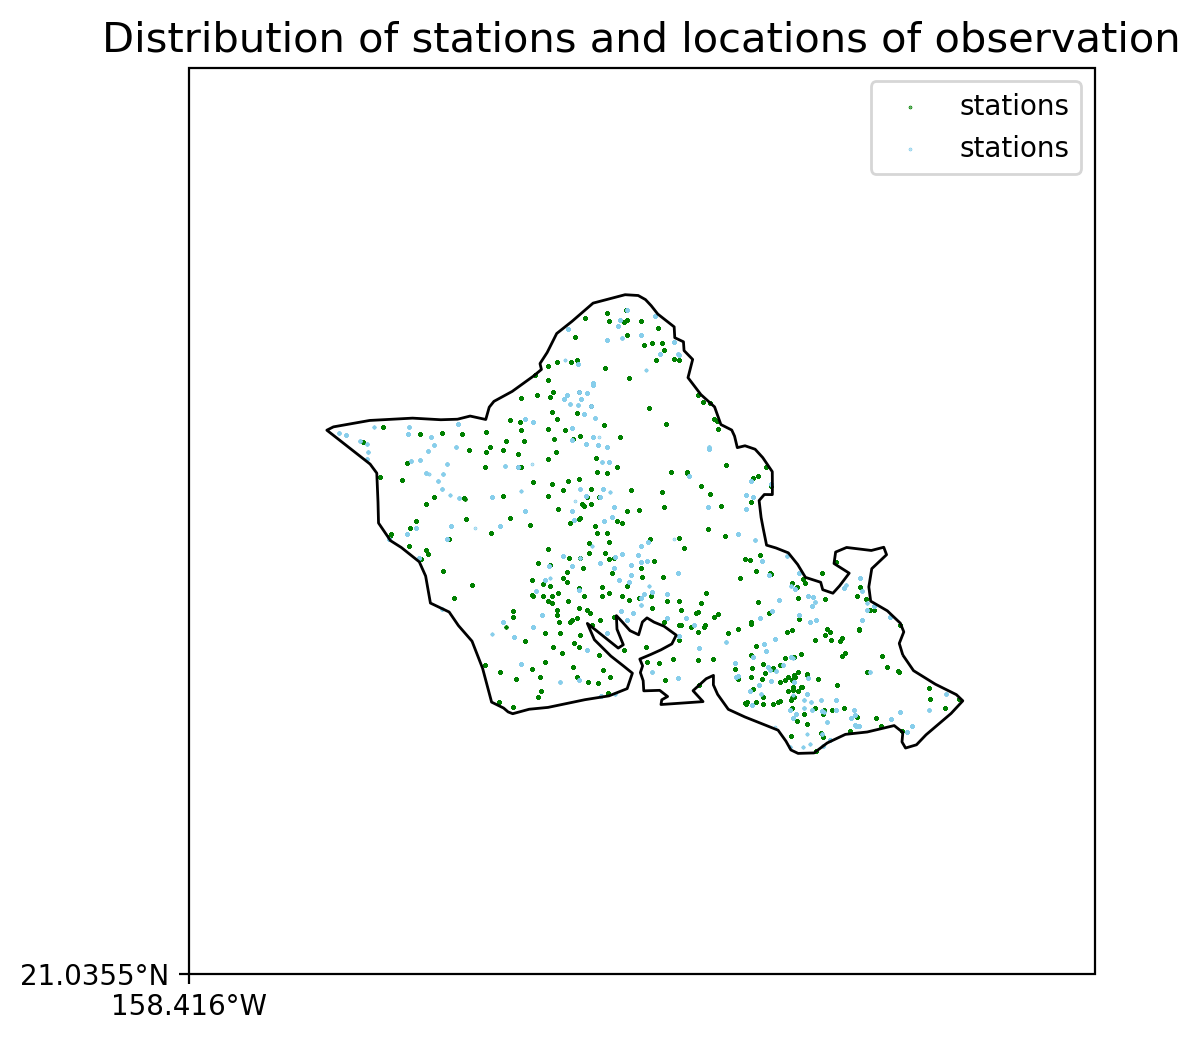

In [320]:
plt.figure(figsize=(10, 6), dpi=200)

ax = plt.axes(projection=ccrs.PlateCarree())

xmin, xmax = -162.5, -152.5
ymin, ymax = 15, 25

lon_oahu = (-157.966174-0.45, -157.966174+0.45)
lat_oahu = (21.485495-0.45, 21.485495+0.45)

xmin, xmax = lon_oahu[0], lon_oahu[1]
ymin, ymax = lat_oahu[0], lat_oahu[1]

ax.set_xticks(np.arange(xmin, xmax+1, 2.5))
ax.set_yticks(np.arange(ymin, ymax+1, 2.5))

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.grid(linewidth=2, color='black', linestyle='--')

stations = plt.scatter(df_linear_better["lon"], df_linear_better["lat"], s=0.1, marker='o', color="green", label="stations")
stations = plt.scatter(df_xgb_better["lon"], df_xgb_better["lat"], s=0.1, marker='o', color="skyblue", label="stations")

plt.vlines(x=np.arange(xmin, xmax+1, 2.5) - 1.25, ymin=ymin, ymax=ymax, color="k", linewidth=1, linestyle="--", alpha=0.5)
plt.hlines(y=np.arange(ymin, ymax+1, 2.5) - 1.25 , xmin=xmin, xmax=xmax, color="k", linewidth=1, linestyle="--", alpha=0.5)
plt.title("Distribution of stations and locations of observation", fontsize=(15))
plt.legend()
ax.coastlines(resolution='10m')
print()
# plt.savefig(f"{BASE_DIR}/images/reanalysis_grids.png")

In [ ]:
fig, ax = plt.subplots(1, figsize=(25,5), dpi=120)
ax.bar(
    x=df_result_per_station['n_data'],
    # height=np.log(1 + df_comparison_mean['diff']),
    # height=diff,
    height = np.log(1 + np.array(df_result_per_station['diff'])),
    width=1,
    color=['b' if item >= 0 else 'r' for item in df_result_per_station['diff']],
    alpha=0.3
)
ax.set_ylim((-5, np.log(np.max(diff)) + 1))
ax.axhline(y=0, linestyle='-', linewidth=1, color='k', alpha=0.2)
ax.axvline(127, linewidth=1, color='orange')
ax.set_title("(rmse_linear - rmse_xgb) per station in log space")
ax.set_xlabel('# of stations')
ax.set_ylabel('log(RMSE+1) in inch')
print()

In [242]:
skn_linear_better = df_result_per_station[df_result_per_station['diff'] < 0]['skn']

In [265]:
df_linear_better = df_combined[df_combined['skn'].isin(skn_linear_better)]
df_xgb_better = df_combined[~df_combined['skn'].isin(skn_linear_better)]

In [279]:
# np.std(df_linear_better[df_linear_better['season_wet'] == 0]['data_in']), np.std(df_linear_better[df_linear_better['season_wet'] == 1]['data_in'])
np.mean(df_linear_better[df_linear_better['season_wet'] == 0]['data_in']), np.mean(df_linear_better[df_linear_better['season_wet'] == 1]['data_in'])

(3.769846639398352, 6.130042011562031)

In [280]:
# np.std(df_xgb_better[df_xgb_better['season_wet'] == 0]['data_in']), np.std(df_xgb_better[df_xgb_better['season_wet'] == 1]['data_in'])
np.mean(df_xgb_better[df_xgb_better['season_wet'] == 0]['data_in']), np.mean(df_xgb_better[df_xgb_better['season_wet'] == 1]['data_in'])

(3.8987494689320394, 6.7906855618971935)

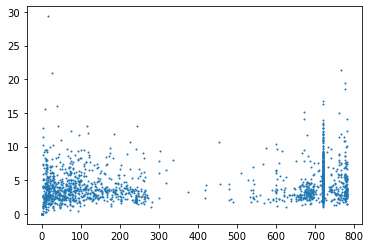

In [271]:
# scatter plot n_data vs std_per_station
n_data = []
std = []
for name, group in df_combined.groupby(by='skn'):
    n_data.append(group.shape[0])
    std.append(np.std(group['data_in']))
    
fig, ax = plt.subplots(1)
ax.scatter(n_data, std, s=1)

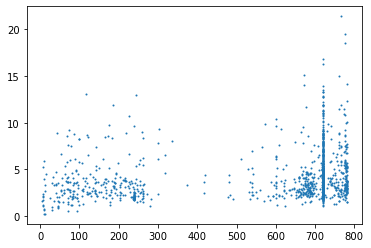

In [272]:
# scatter plot n_data vs std_per_station
n_data = []
std = []
for name, group in df_linear_better.groupby(by='skn'):
    n_data.append(group.shape[0])
    std.append(np.std(group['data_in']))
    
fig, ax = plt.subplots(1)
ax.scatter(n_data, std, s=1)

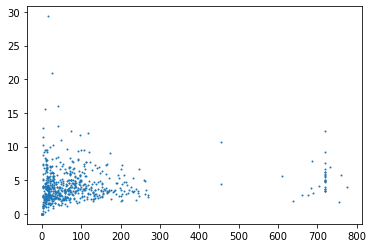

In [273]:
# scatter plot n_data vs std_per_station
n_data = []
std = []
for name, group in df_xgb_better.groupby(by='skn'):
    n_data.append(group.shape[0])
    std.append(np.std(group['data_in']))
    
fig, ax = plt.subplots(1)
ax.scatter(n_data, std, s=1)

In [ ]:
# for each station, calculate teh standard deviation: if more samples=>less varance, AND variance ACROSS station is high=> linear regression is advantageous

### justification on the difference from the past experiments
1. Basemodel_Comparison.ipynb: data split was inappropriate


In [ ]:
n

In [ ]:
# use (Sin, cos) for month